In [1]:
# Importa Qistkit y verifica la versión
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram

Vamos a ver la implementación del medio sumador

* Queremos 2 bits para operar y 2 qubits para leer.
* Usaremos solo 2 bits clásicos ya que vamos a medir una cadena de 2 bits.
* Usaremos 2 CNOTs ya que queremos llevar el resultado de las sumas a 2 qubits distintos (y no sobrescribir), por lo que aplicaremos 1 CNOT respecto a cada qubit de lectura.

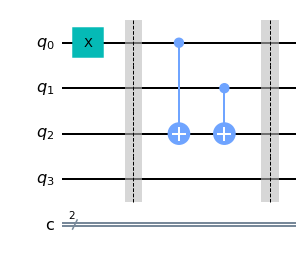

In [5]:
# 4 qubits y 2 clásicos para leer el resultado
qc_ha = QuantumCircuit(4,2)

# Codificamos entradas
qc_ha.x(0)

# Dividimos con una barrera en todos los bits
qc_ha.barrier() 

# CNOTs para sumar, invertimos los control y target en cada uno 
qc_ha.cx(0,2)
qc_ha.cx(1,2)

# Dividimos con una barrera en todos los bits
qc_ha.barrier() 

### Dibujamos ###
qc_ha.draw('mpl')

Es decir, tenemos nuestras entradas `q0` y `q1`, y el resultado de sumar estás irá a parar al bit menos significativo de lectura (`q2`) para los casos de 0+1 y 1+0. Hasta aquí todo bien, pero aún necesitamos el bit de acarreo para el caso 1+1 donde requerimos del siguiente bit más significativo de lectura `q3`. Así que tenemos que implementarlo.

Pensemo en el proceso:

* Si `q0` está en 1 y `q1` en 0 , entonces `q2` está en 1.
* Si `q0` está en 0 y `q1` en 1 , entonces `q2` está en 1.
* Si `q0` está en 1 y `q1` en 1 , entonces `q2` está en 0.

Por lo que por sí mismo el bit `q2` se pone en 0 cuando tiene ambos 1's. 
Así que solo nos vamos a concentrar en colocar nuestro carry en 1 cuando ambos sean 1's. Intuitivamente, sabemos que esto se hace con una AND y una NOT. Y aquí es donde entra en juego la hermana mayor de la **CX**, la **CCX**. Por su nombre **Controlled-Controlled-Not** o más conocida como **Compuerta Toffoli**.

La agregamos a nuestro circuito anterior del medio sumador para completarlo. Agregamos la Toffoli al qubit #3 ya que es nuestro carry:

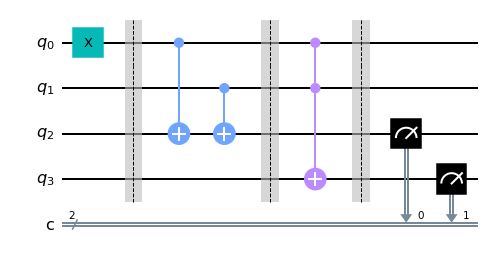

In [6]:
# 4 qubits y 2 clásicos para leer el resultado
qc_ha = QuantumCircuit(4,2)


# Codificamos entradas
qc_ha.x(0)
# Dividimos con una barrera en todos los bits
qc_ha.barrier() 


# CNOTs para sumar, invertimos los control y target en cada uno 
qc_ha.cx(0,2)
qc_ha.cx(1,2)
# Dividimos con una barrera en todos los bits
qc_ha.barrier() 

### Toffoli ###
qc_ha.ccx(0,1,3) 
# Dividimos con una barrera en todos los bits
qc_ha.barrier() 

# Esta es otra forma de medir
# Primero le pasamos los qubits a medir
# y luego los bits clásicos donde se miden cada uno
qc_ha.measure([2,3],[0,1])
              
### Dibujamos ###
qc_ha.draw('mpl')

Vamos a revisar el resultado:

In [9]:
# Creamos una variable donde hacemos una llamada a Aer que es uno de los componentes de Qiskit
# que nos proporciona simuladores de computación cuántica de alto rendimiento con modelos 
# realistas de ruido. (como el que sufre una computadora cuántica al perder información)
# El simulador qasm requiere de mediciones para funcionar correctamente 
sim = Aer.get_backend('qasm_simulator')

# El resultado sera el método .run() de nuestra simulación pasandole el objeto cuántico qobj
# y obtenemos el resultado con el método .result()
result = sim.run(qobj).result()

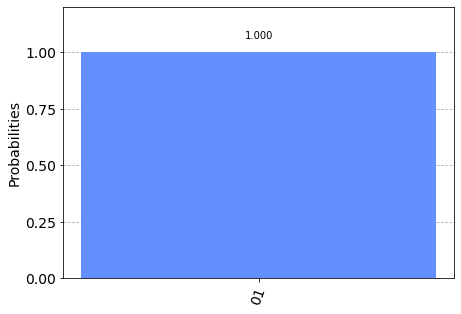

In [10]:
# Convertimos nuestro circuito cuántico en un objeto que nuestro backend sabe ejecutar
qobj = assemble(qc_ha)

# Obtenemos el conteo de resultados
counts = result.get_counts()

plot_histogram(counts)

---